###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, C.D. Cooper.

# Spreading out

We're back! This is the fourth notebook of _Spreading out: parabolic PDEs,_  Module 4 of the course [**"Practical Numerical Methods with Python"**](https://openedx.seas.gwu.edu/courses/course-v1:MAE+MAE6286+2017/about). 

In the [previous notebook](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_03_Heat_Equation_2D_Explicit.ipynb), we solved a 2D problem for the first time, using an explicit scheme. We know explicit schemes have stability constraints that might make them impractical in some cases, due to requiring a very small time step. Implicit schemes are unconditionally stable, offering the advantage of larger time steps; in [notebook 2](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb), we look at the 1D implicit solution of diffusion. Already, that was quite a lot of work: setting up a matrix of coefficients and a right-hand-side vector, while taking care of the boundary conditions, and then solving the linear system. And now, we want to do implicit schemes in 2D—are you ready for this challenge?

## 2D Heat conduction

We already studied 2D heat conduction in the previous lesson, but now we want to work out how to build an implicit solution scheme. To refresh your memory, here is the heat equation again:

$$
\begin{equation}
\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)
\end{equation}
$$

Our previous solution used a Dirichlet boundary condition on the left and bottom boundaries, with $T(x=0)=T(y=0)=100$, and a Neumann boundary condition with zero flux on the top and right edges, with $q_x=q_y=0$.

$$
\left( \left.\frac{\partial T}{\partial y}\right|_{y=0.1} = q_y \right) \quad \text{and} \quad \left( \left.\frac{\partial T}{\partial x}\right|_{x=0.1} = q_x \right)
$$

Figure 1 shows a sketch of the problem set up for our hypothetical computer chip with two hot edges and two insulated edges.

#### <img src="./figures/2dchip.svg" width="400px">  Figure 1: Simplified microchip problem setup.

### Implicit schemes in 2D

An implicit discretization will evaluate the spatial derivatives at the next time level, $t^{n+1}$, using the unknown values of the solution variable. For the 2D heat equation with central difference in space, that is written as:

$$
\begin{equation}
    \begin{split}
        & \frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = \\
        & \quad \alpha \left( \frac{T^{n+1}_{i+1, j} - 2T^{n+1}_{i,j} + T^{n+1}_{i-1,j}}{\Delta x^2} + \frac{T^{n+1}_{i, j+1} - 2T^{n+1}_{i,j} + T^{n+1}_{i,j-1}}{\Delta y^2} \right) \\
    \end{split}
\end{equation}
$$

This equation looks better when we put what we *don't know* on the left and what we *do know* on the right. Make sure to work this out yourself on a piece of paper.

$$
\begin{equation}
    \begin{split}
        & -\frac{\alpha \Delta t}{\Delta x^2} \left( T^{n+1}_{i-1,j} + T^{n+1}_{i+1,j} \right) + \left( 1 + 2 \frac{\alpha \Delta t}{\Delta x^2} + 2 \frac{\alpha \Delta t}{\Delta y^2} \right) T^{n+1}_{i,j} \\
& \quad \quad \quad -\frac{\alpha \Delta t}{\Delta y^2} \left( T^{n+1}_{i,j-1} + T^{n+1}_{i,j+1} \right) = T^n_{i,j} \\
    \end{split}
\end{equation}
$$

To make this discussion easier, let's assume that the mesh spacing is the same in both directions and $\Delta x=\Delta y = \delta$:

$$
\begin{equation}
-T^{n+1}_{i-1,j} - T^{n+1}_{i+1,j} + \left(\frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{i,j} - T^{n+1}_{i,j-1}-T^{n+1}_{i,j+1} = \frac{\delta^2}{\alpha \Delta t}T^n_{i,j}
\end{equation}
$$

Just like in the one-dimensional case, $T_{i,j}$ appears in the equation for $T_{i-1,j}$, $T_{i+1,j}$, $T_{i,j+1}$ and $T_{i,j-1}$, and we can form a linear system to advance in time. But, how do we construct the matrix in this case? What are the $(i+1,j)$, $(i-1,j)$, $(i,j+1)$, and $(i,j-1)$ positions in the matrix?

With explicit schemes we don't need to worry about these things. We can lay out the data just as it is in the physical problem.  We had an array `T` that was a 2-dimensional matrix. To fetch the temperature in the next node in the $x$ direction $(T_{i+1,j})$ we just did `T[j,i+1]`, and likewise in the $y$ direction $(T_{i,j+1})$ was in `T[j+1,i]`. In implicit schemes, we need to think a bit harder about how the data is mapped to the physical problem.

Also, remember from the [notebook on 1D-implicit schemes](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb) that the linear system had $N-2$ elements? We applied boundary conditions on nodes $i=0$ and $i=N-1$, and they were not modified by the linear system. In 2D, this becomes a bit more complicated.

Let's use Figure 1, representing a set of grid nodes in two dimensions, to guide the discussion.

#### <img src="./figures/2D_discretization.png">  Figure 2: Layout of matrix elements in 2D problem

Say we have the 2D domain of size $L_x\times L_y$ discretized in $n_x$ and $n_y$ points. We can divide the nodes into boundary nodes (empty circles) and interior nodes (filled circles).

The boundary nodes, as the name says, are on the boundary. They are the nodes with indices $(i=0,j)$, $(i=n_x-1,j)$, $(i,j=0)$, and $(i,j=n_y-1)$, and boundary conditions are enforced there.

The interior nodes are not on the boundary, and the finite-difference equation acts on them. If we leave the boundary nodes aside for the moment, then the grid will have $(n_x-2)\cdot(n_y-2)$ nodes that need to be updated on each time step. This is the number of unknowns in the linear system. The matrix of coefficients will have $\left( (n_x-2)\cdot(n_y-2) \right)^2$ elements (most of them zero!).

To construct the matrix, we will iterate over the nodes in an x-major order: index $i$ will run faster. The order will be 

*  $(i=1,j=1)$
*  $(i=2,j=1)$ ...
*  $(i=nx-2,j=1)$
*  $(i=1,j=2)$
*  $(i=2,j=2)$ ... 
*  $(i=n_x-2,j=n_y-2)$. 

That is the ordering represented by dotted line on Figure 1. Of course, if you prefer to organize the nodes differently, feel free to do so!

Because we chose this ordering, the equation for nodes $(i-1,j)$ and $(i+1,j)$ will be just before and after $(i,j)$, respectively. But what about $(i,j-1)$ and $(i,j+1)$? Even though in the physical problem they are very close, the equations are $n_x-2$ places apart! This can tie your head in knots pretty quickly. 

_The only way to truly understand it is to make your own diagrams and annotations on a piece of paper and reconstruct this argument!_

### Boundary conditions

Before we attempt to build the matrix, we need to think about boundary conditions. There is some bookkeeping to be done here, so bear with us for a moment.

Say, for example, that the left and bottom boundaries have Dirichlet boundary conditions, and the top and right boundaries have Neumann boundary conditions.

Let's look at each case:

**Bottom boundary:**
    
The equation for $j=1$ (interior points adjacent to the bottom boundary) uses values from $j=0$, which are known. Let's put that on the right-hand side of the equation. We get this equation for all points across the $x$-axis that are adjacent to the bottom boundary:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{i-1,1} - T^{n+1}_{i+1,1} + \left( \frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{i,1} - T^{n+1}_{i,j+1} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{i,1} + T^{n+1}_{i,0} & \\
    \end{split}
\end{equation}
$$

**Left boundary:**

Like for the bottom boundary, the equation for $i=1$ (interior points adjacent to the left boundary) uses known values from $i=0$, and we will put that on the right-hand side:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{2,j} + \left( \frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{1,j} - T^{n+1}_{1,j-1} - T^{n+1}_{1,j+1} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{1,j} + T^{n+1}_{0,j} & \\
    \end{split}
\end{equation}
$$

**Right boundary:**

Say the boundary condition is $\left. \frac{\partial T}{\partial x} \right|_{x=L_x} = q_x$. Its finite-difference approximation  is

$$
\begin{equation}
    \frac{T^{n+1}_{n_x-1,j} - T^{n+1}_{n_x-2,j}}{\delta} = q_x
\end{equation}
$$

We can write $T^{n+1}_{n_x-1,j} = \delta q_x + T^{n+1}_{n_x-2,j}$ to get the finite difference equation for $i=n_x-2$:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{n_x-3,j} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{n_x-2,j} - T^{n+1}_{n_x-2,j-1} - T^{n+1}_{n_x-2,j+1} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{n_x-2,j} + \delta q_x & \\
    \end{split}
\end{equation}
$$

Not sure about this? Grab pen and paper! _Please_, check this yourself. It will help you understand!

**Top boundary:**

Neumann boundary conditions specify the derivative normal to the boundary: $\left. \frac{\partial T}{\partial y} \right|_{y=L_y} = q_y$. No need to repeat what we did for the right boundary, right? The equation for $j=n_y-2$ is

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{i-1,n_y-2} - T^{n+1}_{i+1,n_y-2} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{i,n_y-2} - T^{n+1}_{i,n_y-3} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{i,n_y-2} + \delta q_y & \\
    \end{split}
\end{equation}
$$

So far, we have then 5 possible cases: bottom, left, right, top, and interior points. Does this cover everything? What about corners?

**Bottom-left corner**

At $T_{1,1}$ there is a Dirichlet boundary condition at $i=0$ and $j=0$. This equation is:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{2,1} + \left( \frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{1,1} - T^{n+1}_{1,2} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{1,1} + T^{n+1}_{0,1} + T^{n+1}_{1,0} & \\
    \end{split}
\end{equation}
$$

**Top-left corner:**

At $T_{1,n_y-2}$ there is a Dirichlet boundary condition at $i=0$ and a Neumann boundary condition at $i=n_y-1$. This equation is:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{2,n_y-2} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{1,n_y-2} - T^{n+1}_{1,n_y-3} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{1,n_y-2} + T^{n+1}_{0,n_y-2} + \delta q_y & \\
    \end{split}
\end{equation}
$$

**Top-right corner**

At $T_{n_x-2,n_y-2}$, there are Neumann boundary conditions at both $i=n_x-1$ and $j=n_y-1$. The finite difference equation is then

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{n_x-3,n_y-2} + \left( \frac{\delta^2}{\alpha \Delta t} + 2 \right) T^{n+1}_{n_x-2,n_y-2} - T^{n+1}_{n_x-2,n_y-3} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{n_x-2,n_y-2} + \delta(q_x + q_y) & \\
    \end{split}
\end{equation}
$$

**Bottom-right corner**

To calculate $T_{n_x-2,1}$ we need to consider a Dirichlet boundary condition to the bottom and a Neumann boundary condition to the right. We will get a similar equation to the top-left corner!

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{n_x-3,1} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{n_x-2,1} - T^{n+1}_{n_x-2,2} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{n_x-2,1} + T^{n+1}_{n_x-2,0} + \delta q_x & \\
    \end{split}
\end{equation}
$$

Okay, now we are actually ready. We have checked every possible case!

### The linear system

Like in the previous lesson introducing implicit schemes, we will solve a linear system at every time step:

$$
[A][T^{n+1}_\text{int}] = [b]+[b]_{b.c.}
$$

The coefficient matrix now takes some more work to figure out and to build in code. There is no substitute for you working this out patiently on paper!

The structure of the matrix can be described as a series of diagonal blocks, and lots of zeros elsewhere. Look at Figure 3, representing the block structure of the coefficient matrix, and refer back to Figure 2, showing the discretization grid in physical space. The first row of interior points, adjacent to the bottom boundary, generates the matrix block labeled $A_1$. The top row of interior points, adjacent to the top boundary generates the matrix block labeled $A_3$. All other interior points in the grid generate similar blocks, labeled $A_2$ on Figure 3.

#### <img src="./figures/implicit-matrix-blocks.png">  Figure 3: Sketch of coefficient-matrix blocks.

#### <img src="./figures/matrix-blocks-on-grid.png">  Figure 4: Grid points corresponding to each matrix-block type.

The matrix block $A_1$ is

<img src="./figures/A_1.svg"  width="640px">

The block matrix $A_2$ is

<img src="./figures/A_2.svg"  width="640px">

The block matrix $A_3$ is

<img src="./figures/A_3.svg"  width="640px">

Vector $T^{n+1}_\text{int}$ contains the temperature of the interior nodes in the next time step. It is:

$$
\begin{equation}
T^{n+1}_\text{int} = \left[
\begin{array}{c}
T^{n+1}_{1,1}\\
T^{n+1}_{2,1} \\
\vdots \\
T^{n+1}_{n_x-2,1} \\
T^{n+1}_{2,1} \\
\vdots \\
T^{n+1}_{n_x-2,n_y-2}
\end{array}
\right]
\end{equation}
$$

Remember the x-major ordering we chose!

Finally, the right-hand side is
\begin{equation}
[b]+[b]_{b.c.} = 
\left[\begin{array}{c}
\sigma^\prime T^n_{1,1} + T^{n+1}_{0,1} + T^{n+1}_{1,0} \\
\sigma^\prime T^n_{2,0} + T^{n+1}_{2,0} \\
\vdots \\
\sigma^\prime T^n_{n_x-2,1} + T^{n+1}_{n_x-2,0} + \delta q_x \\
\sigma^\prime T^n_{1,2} + T^{n+1}_{0,2} \\
\vdots \\
\sigma^\prime T^n_{n_x-2,n_y-2} + \delta(q_x + q_y)
\end{array}\right]
\end{equation}

where $\sigma^\prime = 1/\sigma = \delta^2/\alpha \Delta t$. The matrix looks very ugly, but it is important you understand it! Think about it. Can you answer:
   * Why a -1 factor appears $n_x-2$ columns after the diagonal? What about $n_x-2$ columns before the diagonal?
   * Why in row $n_x-2$ the position after the diagonal contains a 0?
   * Why in row $n_x-2$ the diagonal is $\sigma^\prime + 3$ rather than $\sigma^\prime + 4$?
   * Why in the last row the diagonal is $\sigma^\prime + 2$ rather than $\sigma^\prime + 4$?
   
If you can answer those questions, you are in good shape to continue!

Let's write a function that will generate the matrix and right-hand side for the heat conduction problem in the previous notebook. Remember, we had Dirichlet boundary conditions in the left and bottom, and zero-flux Neumann boundary condition on the top and right $(q_x=q_y=0)$. 

Also, we'll import `scipy.linalg.solve` because we need to solve a linear system.

In [1]:
import numpy
from scipy import linalg

In [2]:
def lhs_operator(M, N, sigma):
    """
    Assembles and returns the implicit operator
    of the system for the 2D diffusion equation.
    We use a Dirichlet condition at the left and
    bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    M : integer
        Number of interior points in the x direction.
    N : integer
        Number of interior points in the y direction.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size M*N by M*N.
    """
    A = numpy.zeros((M * N, M * N))
    for j in range(N):
        for i in range(M):
            I = j * M + i  # row index
            # Get index of south, west, east, and north points.
            south, west, east, north = I - M, I - 1, I + 1, I + M
            # Setup coefficients at corner points.
            if i == 0 and j == 0:  # bottom-left corner
                A[I, I] = 1.0 / sigma + 4.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1 and j == 0:  # bottom-right corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif i == 0 and j == N - 1:  # top-left corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, east] = -1.0
            elif i == M - 1 and j == N - 1:  # top-right corner
                A[I, I] = 1.0 / sigma + 2.0
                A[I, south] = -1.0
                A[I, west] = -1.0
            # Setup coefficients at side points (excluding corners).
            elif i == 0:  # left side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1:  # right side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif j == 0:  # bottom side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif j == N - 1:  # top side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
            # Setup coefficients at interior points.
            else:
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
    return A

In [3]:
def rhs_vector(T, M, N, sigma, Tb):
    """
    Assembles and returns the right-hand side vector
    of the system for the 2D diffusion equation.
    We use a Dirichlet condition at the left and
    bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    M : integer
        Number of interior points in the x direction.
    N : integer
        Number of interior points in the y direction.
    sigma : float
        Value of alpha * dt / dx**2.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side vector as a 1D array of floats
        of size M*N.
    """
    b = 1.0 / sigma * T
    # Add Dirichlet term at points located next
    # to the left and bottom boundaries.
    for j in range(N):
        for i in range(M):
            I = j * M + i
            if i == 0:
                b[I] += Tb
            if j == 0:
                b[I] += Tb
    return b

The solution of the linear system $(T^{n+1}_\text{int})$ contains the temperatures of the interior points at the next time step in a 1D array. We will also create a function that will take the values of $T^{n+1}_\text{int}$ and put them in a 2D array that resembles the physical domain.

In [4]:
def map_1d_to_2d(T_1d, nx, ny, Tb):
    """
    Maps a 1D array of the temperature at the interior points
    to a 2D array that includes the boundary values.
    
    Parameters
    ----------
    T_1d : numpy.ndarray
        The temperature at the interior points as a 1D array of floats.
    nx : integer
        Number of points in the x direction of the domain.
    ny : integer
        Number of points in the y direction of the domain.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution in the domain
        as a 2D array of size ny by nx.
    """
    T = numpy.zeros((ny, nx))
    # Get the value at interior points.
    T[1:-1, 1:-1] = T_1d.reshape((ny - 2, nx - 2))
    # Use Dirichlet condition at left and bottom boundaries.
    T[:, 0] = Tb
    T[0, :] = Tb
    # Use Neumann condition at right and top boundaries.
    T[:, -1] = T[:, -2]
    T[-1, :] = T[-2, :]
    return T

And to advance in time, we will use

In [5]:
def btcs_implicit_2d(T0, nt, dt, dx, alpha, Tb):
    """
    Computes and returns the distribution of the
    temperature after a given number of time steps.
    
    The 2D diffusion equation is integrated using
    Euler implicit in time and central differencing
    in space, with a Dirichlet condition at the left
    and bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x and y directions.
    alpha : float
        Thermal diffusivity of the plate.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Get the number of points in each direction.
    ny, nx = T0.shape
    # Get the number of interior points in each direction.
    M, N = nx - 2, ny - 2
    # Compute the constant sigma.
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(M, N, sigma)
    # Integrate in time.
    T = T0[1:-1, 1:-1].flatten()  # interior points as a 1D array
    I, J = int(M / 2), int(N / 2)  # indices of the center
    for n in range(nt):
        # Compute the right-hand side of the system.
        b = rhs_vector(T, M, N, sigma, Tb)
        # Solve the system with scipy.linalg.solve.
        T = linalg.solve(A, b)
        # Check if the center of the domain has reached T = 70C.
        if T[J * M + I] >= 70.0:
            break
    print('[time step {}] Center at T={:.2f} at t={:.2f} s'
          .format(n + 1, T[J * M + I], (n + 1) * dt))
    # Returns the temperature in the domain as a 2D array.
    return map_1d_to_2d(T, nx, ny, Tb)

Remember, we want the function to tell us when the center of the plate reaches $70^\circ C$.

##### Dig deeper

For demonstration purposes, these functions are very explicit. But you can see a trend here, right? 

Say we start with a matrix with `1/sigma+4` in the main diagonal, and `-1` on the 4 other corresponding diagonals. Now, we have to modify the matrix only where the boundary conditions are affecting. We saw the impact of the Dirichlet and Neumann boundary condition on each position of the matrix, we just need to know in which position to perform those changes. 

A function that maps `i` and `j` into `row_number` would be handy, right? How about `row_number = (j-1)*(nx-2)+(i-1)`? By feeding `i` and `j` to that equation, you know exactly where to operate on the matrix. For example, `i=nx-2, j=2`, which is in row `row_number = 2*nx-5`, is next to a Neumann boundary condition: we have to substract one out of the main diagonal (`A[2*nx-5,2*nx-5]-=1`), and put a zero in the next column (`A[2*nx-5,2*nx-4]=0`). This way, the function can become much simpler!

Can you use this information to construct a more general function `lhs_operator`? Can you make it such that the type of boundary condition is an input to the function? 

## Heat diffusion in 2D

Let's recast the 2D heat conduction from the previous notebook, and solve it with an implicit scheme. 

In [6]:
# Set parameters.
Lx = 0.01  # length of the plate in the x direction
Ly = 0.01  # length of the plate in the y direction
nx = 21  # number of points in the x direction
ny = 21  # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction
alpha = 1e-4  # thermal diffusivity

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Compute the initial temperature distribution.
Tb = 100.0  # temperature at the left and bottom boundaries
T0 = 20.0 * numpy.ones((ny, nx))
T0[:, 0] = Tb
T0[0, :] = Tb

We are ready to go!

In [7]:
# Set the time-step size based on CFL limit.
sigma = 0.25
dt = sigma * min(dx, dy)**2 / alpha  # time-step size
nt = 300  # number of time steps to compute

# Compute the temperature along the rod.
T = btcs_implicit_2d(T0, nt, dt, dx, alpha, Tb)

[time step 257] Center at T=70.00 at t=0.16 s


And plot,

In [8]:
from matplotlib import pyplot
%matplotlib inline

In [9]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

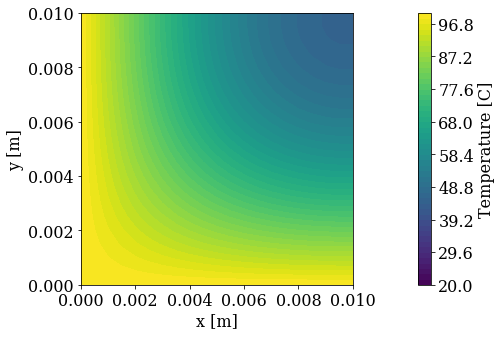

In [10]:
# Plot the filled contour of the temperature.
pyplot.figure(figsize=(8.0, 5.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
levels = numpy.linspace(20.0, 100.0, num=51)
contf = pyplot.contourf(x, y, T, levels=levels)
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]')
pyplot.axis('scaled', adjustable='box');

Try this out with different values of `sigma`! You'll see that it will always give a stable solution!

Does this result match the explicit scheme from the previous notebook? Do they take the same amount of time to reach $70^\circ C$ in the center of the plate? Now that we can use higher values of `sigma`, we need fewer time steps for the center of the plate to reach $70^\circ C$! Of course, we need to be careful that `dt` is small enough to resolve the physics correctly.

---
###### The cell below loads the style of the notebook

In [11]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())